<a href="https://colab.research.google.com/github/lookmeebbear/GeoProg_MIST2024/blob/main/CNNforRS_Regression_Lookmee_MIST2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SAR to NDVI Conversion -- Mission Impossible ??**

Thepchai Srinoi

Department of Survey Engineering

Chulalongkorn University

ปกติ ภาพเชิงทัศน์จะมีปัญหาในภูมิภาคร้อนชื้น มรสุม เมฆมักปกคลุมบ่อย (พบได้ในภาคใต้ของประเทศไทย) เวลาจะหา NDVI ก็จะยากมาก แต่ภาพซาร์ไร้ปัญหา แต่ไม่ได้บอกตรงๆ ถ้าเราหา SAR NDVI ได้ก็จะเติมเต็มข้อมูลได้ ทางออกของปัญหาน่าจะใช้ Convolution Neural Network สร้างภาพจาก Ascending/Descending VV VH Sentinel 1A/B แปลงเป็น NDVI ปลอมๆ ทดแทนไปก่อน

SAR Ascending ขาขึ้น 10 ธันวา 2022

Descending ขาลง 14 ธันวา 2022

Optical 12 ธันวา 2022

------------------------------------------------------------
Ascending
S1A_IW_GRDH_1SDV_20221210T112900_20221210T112925_046269_058A71_5C94

Decending
S1A_IW_GRDH_1SDV_20221214T230941_20221214T231006_046334_058CAA_076F

Optical 20221212T034139_20221212T034733_T47PPR

-------------------------------------------------------------


ลง library ที่จำเป็น ทั้งการเปิดภาพ แสดงผลสถาปัตยกรรม การทำแบบจำลองแยกส่วน

In [ ]:
!pip install rasterio visualkeras segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.3 MB/s eta 0:00:00


นำเข้าเครื่องมือที่จำเป็น

In [ ]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist
import visualkeras

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

ดาวน์โหลดข้อมูลทำแบบจำลอง

In [ ]:
# https://drive.google.com/file/d/1SyUMkQKLknil7G5m7s5ej01vQdO48WAc/view?usp=drive_link
!gdown https://drive.google.com/uc?id=1SyUMkQKLknil7G5m7s5ej01vQdO48WAc

Downloading...
From (original): https://drive.google.com/uc?id=1SyUMkQKLknil7G5m7s5ej01vQdO48WAc
From (redirected): https://drive.google.com/uc?id=1SyUMkQKLknil7G5m7s5ej01vQdO48WAc&confirm=t&uuid=2ea0fd0a-7ef9-4c54-93c2-deca7dc2d621
To: /content/Lookmee_NDVI_CNN.zip
100% 471M/471M [00:10<00:00, 44.1MB/s]


แตกไฟล์

In [ ]:
!unzip Lookmee_NDVI_CNN.zip

Archive:  Lookmee_NDVI_CNN.zip
  inflating: mypatch_SNDVI/patchSNDVI_1.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_10.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_100.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1000.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1001.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1002.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1003.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1004.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1005.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1006.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1007.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1008.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1009.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_101.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1010.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1011.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1012.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1013.tiff  
  inflating: mypatch_SNDVI/patchSNDVI_1014.tiff  
  inflating: mypatch_SNDVI

ลองนับจำนวนข้อมูล

In [ ]:
import os
import fnmatch

dir_path = '/content/mypatch_SNDVI/'
count = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
print('File Count:', count)

File Count: 4743


นำภาพเข้าชุดอาร์เรย์ของข้อมูล input และ output

In [ ]:
XImages = np.zeros([count, 64, 64, 4], dtype="float32")
YImages = np.zeros([count, 64, 64, 1], dtype="float32")

for j in range(1,count) :
  with rasterio.open( dir_path + 'patchSNDVI_' + str(j) + '.tiff') as img:
    tmp = np.moveaxis(img.read(), 0, 2)
    XImages[j-1] = tmp[:,:,0:4]
    YImages[j-1] = tmp[:,:,4:5]


สุ่มเปิดภาพดาวเทียม และ ภาพ label

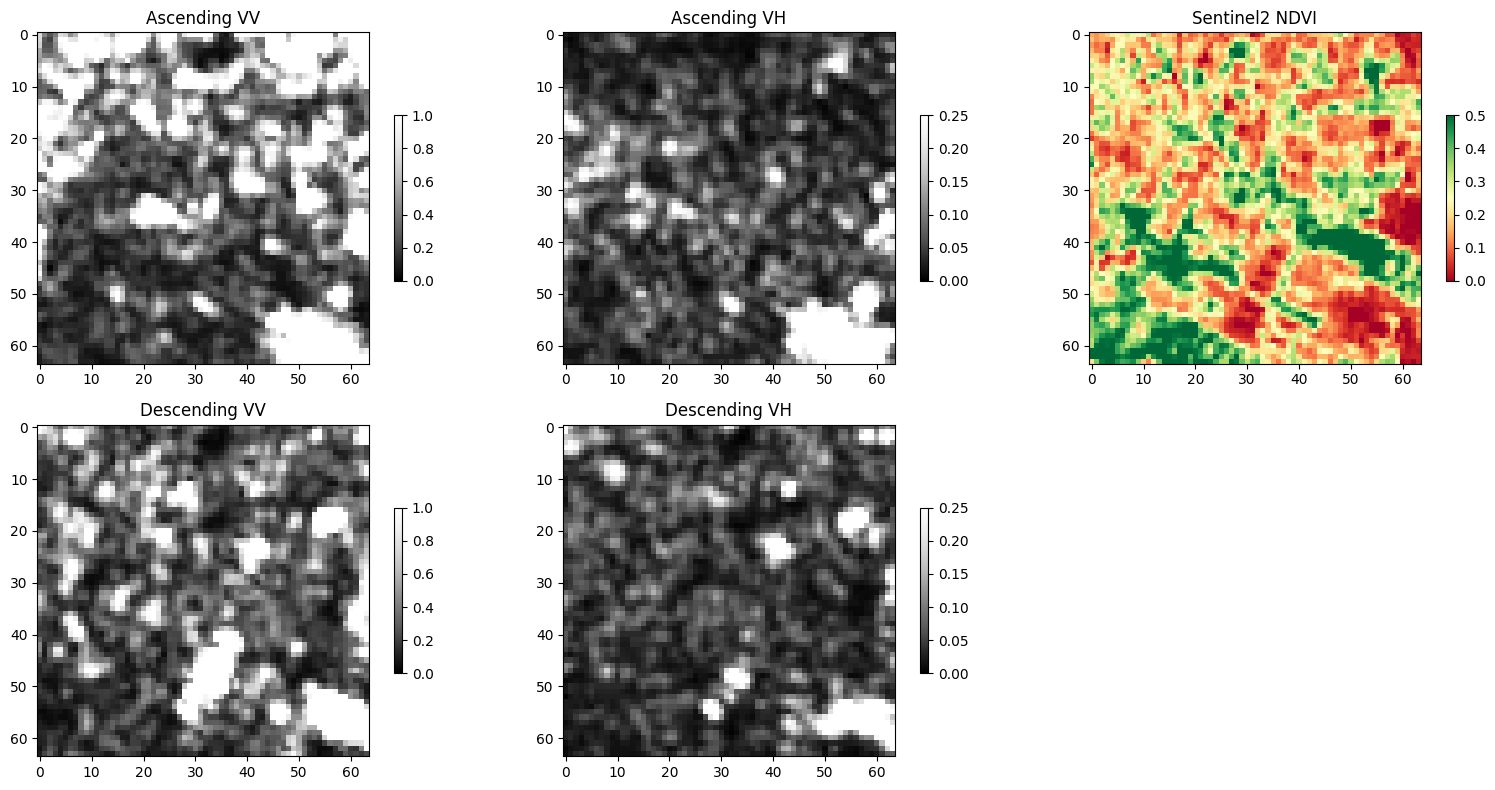

In [ ]:
import random
import matplotlib.pyplot as plt
random_image_id = random.randint(0, count)
plt.figure(figsize=(16,8))

plt.subplot(231)
plt.title("Ascending VV")
plt.imshow(XImages[random_image_id][:,:,0], cmap = 'Greys_r', vmin=0, vmax=1)
plt.colorbar(shrink=0.5)

plt.subplot(232)
plt.title("Ascending VH")
plt.imshow(XImages[random_image_id][:,:,1], cmap = 'Greys_r', vmin=0, vmax=0.25)
plt.colorbar(shrink=0.5)

plt.subplot(234)
plt.title("Descending VV")
plt.imshow(XImages[random_image_id][:,:,2], cmap = 'Greys_r', vmin=0, vmax=1)
plt.colorbar(shrink=0.5)

plt.subplot(235)
plt.title("Descending VH")
plt.imshow(XImages[random_image_id][:,:,3], cmap = 'Greys_r', vmin=0, vmax=0.25)
plt.colorbar(shrink=0.5)

plt.subplot(233)
plt.title("Sentinel2 NDVI")
plt.imshow(YImages[random_image_id][:,:,0], cmap='RdYlGn', vmin=0, vmax=0.5)
plt.colorbar(shrink=0.5)

plt.tight_layout()

แบ่ง train/test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XImages, YImages, train_size = 0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2371, 64, 64, 4)
(2372, 64, 64, 4)
(2371, 64, 64, 1)
(2372, 64, 64, 1)


แปลงจาก NAN เป็น 0 ให้หมด รอบหน้าต้องหาทางทำให้ NAN หายไปตั้งแต่เริ่ม

In [ ]:
X_train = np.where(np.isfinite( X_train ), X_train, 0)
X_test = np.where(np.isfinite( X_test ), X_test, 0)
y_train = np.where(np.isfinite( y_train ), y_train, 0)
y_test = np.where(np.isfinite( y_test ), y_test, 0)

ลง เครื่องมือ ที่เกี่ยวข้องกับการสร้าง สถาปัตยกรรมของแบบจำลอง

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

ตัวอย่างที่น่าสนใจ มั้ง Building Autoencoder from image denoising

https://colab.research.google.com/github/iagml/iagml.github.io/blob/master/assets/uploads/image_denoising.ipynb#scrollTo=NAqXl7JOTcq4

สร้าง สถาปัตยกรรมนิวรอนเส็งเคร็ง UNET ขึ้นมา

In [ ]:
def multi_unet_model(n_classes=12, image_height=64, image_width=64, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="linear")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  #visualkeras.layered_view(model, legend=True )
  #model.summary()
  return model

สร้าง สถาปัตยกรรมนิวรอนเส็งเคร็ง LOOKMEE ขึ้นมา

In [ ]:
def lookmee_model(n_classes=1, image_height=64, image_width=64, image_channels=4):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(source_input)
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  #x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  #x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  encoded = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

  x = Conv2D(filters =  32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
  #x = UpSampling2D(size = (2, 2))(x)
  #x = Conv2D(filters =  32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters =  32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D(size = (2, 2))(x)
  decoded = Conv2D(filters = 1, kernel_size = (2, 2), activation = 'linear', padding = 'same')(x)

  model = Model(inputs=[inputs], outputs=[decoded])
  #visualkeras.layered_view(model, legend=True )
  #model.summary()
  return model

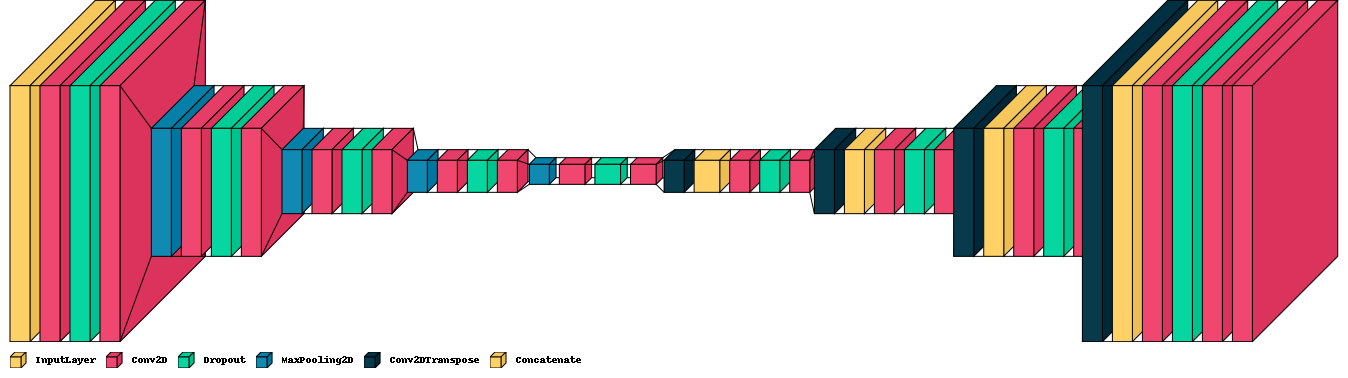

In [ ]:
def get_lookmee_learning_model():
  return lookmee_model(n_classes=1,
                          image_height=64,
                          image_width=64,
                          image_channels=4)

def get_unet_learning_model():
  return multi_unet_model(n_classes=1,
                          image_height=64,
                          image_width=64,
                          image_channels=4)

model = get_unet_learning_model()
visualkeras.layered_view(model, legend=True )

เผื่อ save เผื่อจะสั่งหยุดเลย เผื่อต้องปรับ parameter ระหว่างทาง

In [ ]:
model_file = 'unet.h5'
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [ ]:
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE')])


In [ ]:
print(np.any(np.isnan(X_test)))
print(np.any(np.isnan(y_test)))

False
False


In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=200,
                          validation_data=(X_test, y_test),
                          shuffle=True,
                          callbacks = callback_list)

Epoch 1/200
149/149 [==============================] - 20s 40ms/step - loss: 0.1837 - MAE: 0.1837 - val_loss: 0.1262 - val_MAE: 0.1262 - lr: 0.0010
Epoch 2/200
  1/149 [..............................] - ETA: 2s - loss: 0.1330 - MAE: 0.1330

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 3s 21ms/step - loss: 0.1229 - MAE: 0.1229 - val_loss: 0.1218 - val_MAE: 0.1218 - lr: 0.0010
Epoch 3/200
149/149 [==============================] - 4s 30ms/step - loss: 0.1171 - MAE: 0.1171 - val_loss: 0.1181 - val_MAE: 0.1181 - lr: 0.0010
Epoch 4/200
149/149 [==============================] - 3s 21ms/step - loss: 0.1135 - MAE: 0.1135 - val_loss: 0.1099 - val_MAE: 0.1099 - lr: 0.0010
Epoch 5/200
149/149 [==============================] - 3s 20ms/step - loss: 0.1108 - MAE: 0.1108 - val_loss: 0.1132 - val_MAE: 0.1132 - lr: 0.0010
Epoch 6/200
149/149 [==============================] - 3s 21ms/step - loss: 0.1086 - MAE: 0.1086 - val_loss: 0.1054 - val_MAE: 0.1054 - lr: 0.0010
Epoch 7/200
149/149 [==============================] - 4s 26ms/step - loss: 0.1068 - MAE: 0.1068 - val_loss: 0.1062 - val_MAE: 0.1062 - lr: 0.0010
Epoch 8/200
149/149 [==============================] - 4s 24ms/step - loss: 0.1054 - MAE: 0.1054 - val_loss: 0.1032 - val_MAE: 0.1

ดูผลลัผธ์

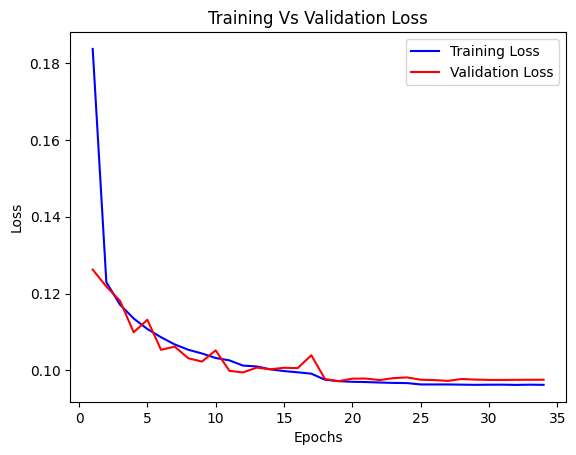

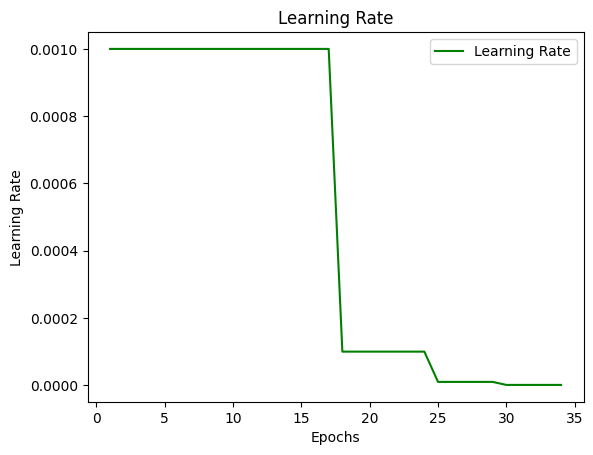

In [ ]:
history_a = model_history
loss = history_a.history['MAE']
val_loss = history_a.history['val_MAE']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

LR = history_a.history['lr']
plt.plot(epochs, LR , 'g', label="Learning Rate")
plt.title("Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

เก็บภาพที่เค้าทำนายไว้

In [ ]:
y_pred = model.predict(X_test)

75/75 [==============================] - 2s 5ms/step


แสดงภาพผลลัผธ์ คั่นกู จุ๊กกู๊

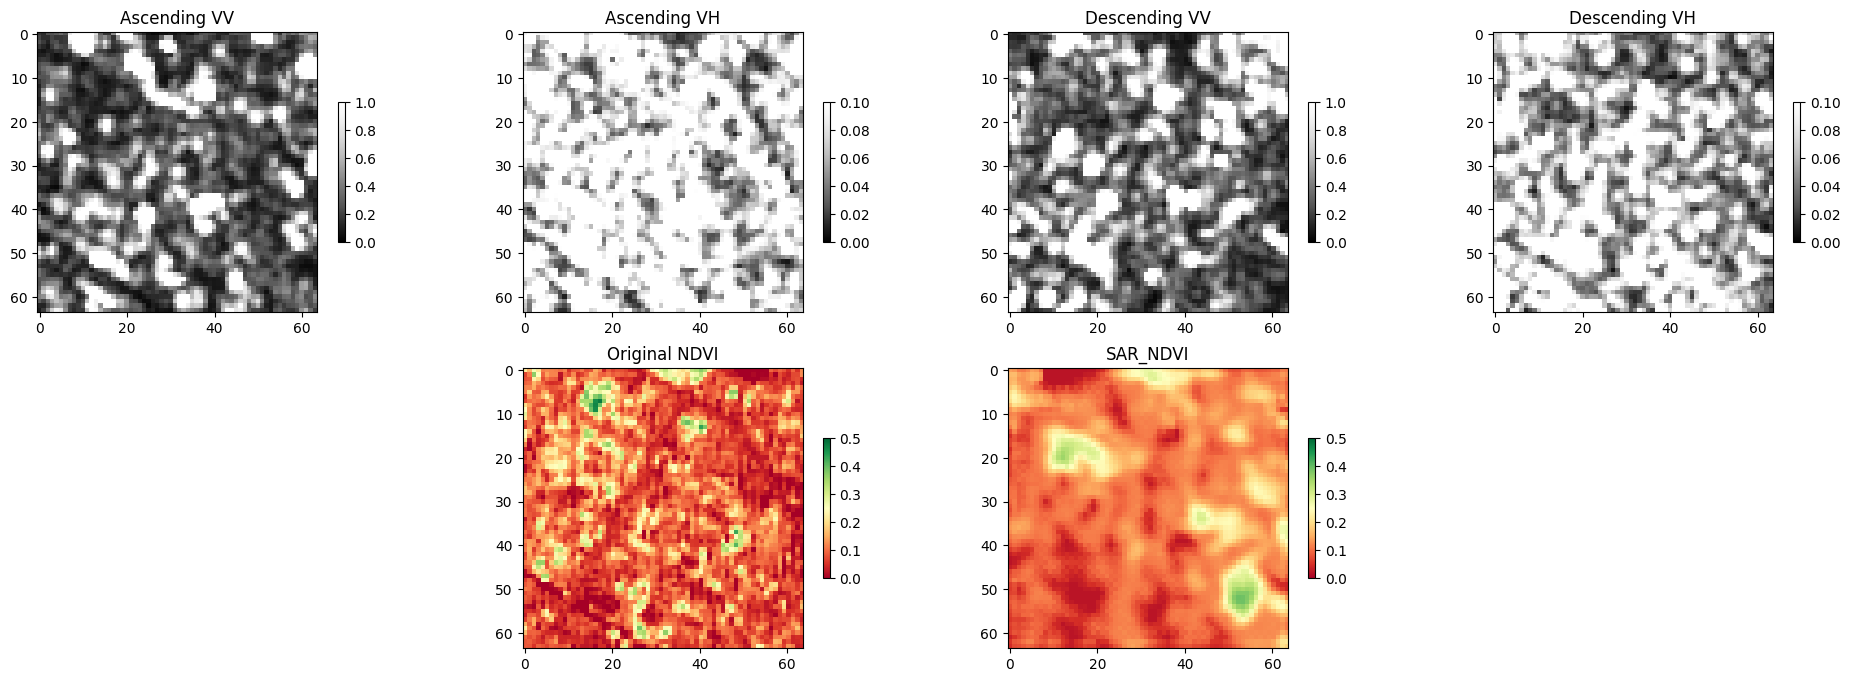

In [ ]:
import random
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test[test_image_number]
predicted_image = y_pred[test_image_number]


plt.figure(figsize=(24,8))

plt.subplot(241)
plt.title("Ascending VV")
plt.imshow(test_image[:,:,0], cmap='Greys_r', vmin=0, vmax=1)
plt.colorbar(shrink=0.5)

plt.subplot(242)
plt.title("Ascending VH")
plt.imshow(test_image[:,:,1], cmap='Greys_r', vmin=0, vmax=0.1)
plt.colorbar(shrink=0.5)

plt.subplot(243)
plt.title("Descending VV")
plt.imshow(test_image[:,:,2], cmap='Greys_r', vmin=0, vmax=1)
plt.colorbar(shrink=0.5)

plt.subplot(244)
plt.title("Descending VH")
plt.imshow(test_image[:,:,3], cmap='Greys_r', vmin=0, vmax=0.1)
plt.colorbar(shrink=0.5)

plt.subplot(246)
plt.title("Original NDVI")
plt.imshow(ground_truth_image, cmap='RdYlGn', vmin=0, vmax=0.5)
plt.colorbar(shrink=0.5)

plt.subplot(247)
plt.title("SAR_NDVI")
plt.imshow(predicted_image, cmap='RdYlGn', vmin= 0, vmax=0.5)
plt.colorbar(shrink=0.5)